In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


In [122]:
path = "../data/clean"
patient_df = pd.read_pickle(f"{path}/patient_level_features_med_num.pkl")
df = pd.read_pickle(f"{path}/feature_ls.pkl")
X_pca = np.load(f"{path}/X_pca.npy")
#labels = np.load(f"{path}/labels.npy")
df_unsup = pd.read_pickle(f"{path}/df_unsupervised_final.pkl")

In [278]:
# readin hcpcs mapper
mapper_path = "../data/mappers"
hcpcs_mapper = pd.read_pickle(f"{mapper_path}/hcpcs.pkl")
drg_mapper = pd.read_pickle(f"{mapper_path}/drg.pkl")

In [279]:
drg_mapper.head()

,DRG,MDC,DRG_description,MDC_description
0,001,NaN,Heart transplant or implant of heart assist sy...,NaN
1,002,NaN,Heart transplant or implant of heart assist sy...,NaN
2,003,NaN,ECMO o r tracheostomy with MV >96 hours or PDX...,NaN
3,004,NaN,Trache ostomy with MV >96 hours or PDX except ...,NaN
4,005,NaN,Liver transplant with MCC or intestinal transp...,NaN


In [18]:
def create_cluster_plot(labels, n_clusters, X_pca, model, axis, model_type):
      
    if model_type == 'dbscan':
            unique_labels = set(labels)
            n_clusters = len([l for l in unique_labels if l != -1])
             
    colors = cm.jet( (labels.astype(float) * 1.5 ) / (n_clusters))
    
    axis.scatter(
            X_pca[:, 0], X_pca[:, 1], 
            marker=".", 
            s=30, 
            lw=0, 
            alpha=0.7, 
            color = colors,
            edgecolor="k"
        )

    # Labeling the clusters
    if model_type == 'km':
        centers = model.cluster_centers_
    elif model_type == 'gmm':
        centers = model.means_
    elif model_type == 'dbscan':
        centers = []
        for label in unique_labels:
            if label == -1:
                continue  # skip noise
            cluster_points = X_pca[labels == label]
            centers.append(list(cluster_points.mean(axis=0)))
            
    # Draw white circles at cluster centers
    axis.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=100,
            edgecolor="k",
        )

    for i, c in enumerate(centers):
        cl = i * 1.5
        axis.scatter(c[0], c[1], 
                marker="$%d$" % i, 
                alpha=1, s=20, 
                color = cm.jet( (cl ) / (n_clusters)))
        axis.set_title("K-Means Clustering Results")
        axis.set_xlabel("1st Feature space")
        axis.set_ylabel("2nd Feature space")
        axis.grid(False)
        
    plt.rcParams['axes.titlesize'] = 8
    plt.rcParams['axes.labelsize'] = 8
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

    plt.show()
    return None

In [123]:
df_desc = pd.merge(df, hcpcs_mapper, how = 'left', left_on = 'feature', right_on = 'Code')

In [124]:
df_desc

,component,feature,Code,Description
0,PC1,HCPCS_level_1,NaN,NaN
1,PC2,S9126,S9126,"Hospice care, in the home, per diem"
2,PC3,G8946,G8946,Minimally invasive biopsy method attempted but...
3,PC4,H2000,H2000,Comprehensive multidisciplinary evaluation
4,PC5,G0444,G0444,"Annual depression screening, 5 to 15 minutes"
5,PC6,T1502,T1502,"Administration of oral, intramuscular and/or s..."
6,PC7,S9473,S9473,"Pulmonary rehabilitation program, non-physicia..."
7,PC8,S0605,NaN,NaN
8,PC9,G0102,G0102,Prostate cancer screening; digital rectal exam...
9,PC10,C8928,C8928,"Transthoracic echocardiography with contrast, ..."


In [125]:
kmeans = KMeans(init = 'k-means++', n_clusters=8, n_init= 5, random_state = 42) 
km = kmeans.fit(X_pca) 
labels = km.predict(X_pca)

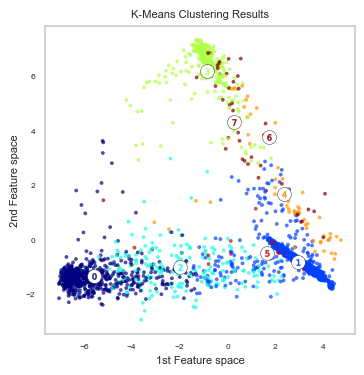

In [126]:
fig, ax = plt.subplots(figsize=(4, 4))
create_cluster_plot(labels, 8, X_pca, km, ax, model_type = 'km')

Look at patients with the most relevant PCA features in combined_hcpcs_ls

In [127]:
ls = [x for x in df_desc['feature']][1:]
ls

['S9126',
 'G8946',
 'H2000',
 'G0444',
 'T1502',
 'S9473',
 'S0605',
 'G0102',
 'C8928',
 'G9708']

In [149]:
# merge on cluster
df_eval = pd.concat([patient_df, df_unsup], axis = 1)

In [151]:
mask = df_eval['combined_hcpcs_ls'].apply(lambda x:list( set([1 for code in x if code in ls]))).apply(lambda x: 1 if len(x) > 0 else 0)

In [152]:
mask.unique()

array([1, 0])

In [153]:
df_eval = df_eval[ mask == 1]

In [ ]:
grp = df_eval.groupby('cluster')['combined_principal_diagnosis_ls'].apply(list)
grp_df = pd.DataFrame(grp)
grp_df.reset_index(drop=True, inplace=True)
grp_df

,combined_principal_diagnosis_ls
0,"[[E785, N390, E785, E785, E785, E785, E785, E7..."
1,"[[E785, E785, E785, E785, B085, E785, E785, J0..."
2,"[[J209, S93409, J0190, J0190, F0280, B9789, B9..."
3,"[[M810, M810, M810, M810, M810, M810, M810, M8..."
4,"[[C50929, C50919, J45909, J45909, C50929, C509..."
5,"[[Z3480, Z3480, J0190, J0190, J0190, J0190, J0..."
6,"[[M179, H6690, J329, J329, J329, J329, J329, J..."
7,"[[J329, J329, C50929, C50919, C50929, C50929, ..."
8,"[[O039, O039, B002, B002, B085, O039, S8290X, ..."


In [262]:
grp_df['test'] = grp_df['combined_principal_diagnosis_ls'].apply(lambda x: list(set([item for ls in x for item in ls])))

In [272]:
grp_df['drg_ls_len'] = grp_df['test'].str.len()
vals = grp_df['drg_ls_len'].value_counts()
pd.DataFrame({
  'len_breakdown': vals
}).head(10)

,len_breakdown
drg_ls_len,
122,2
138,1
132,1
108,1
56,1
41,1
46,1
36,1


In [273]:
grp = df_eval.groupby('cluster')['drg_ls'].apply(list)
grp_df = pd.DataFrame(grp)
grp_df.reset_index(drop=True, inplace=True)
grp_df

,drg_ls
0,"[[], [], [012, 157, 103, 794, 159, 102, 102, 9..."
1,"[[], [], [001], [001], [001, 001, 001, 001, 00..."
2,"[[001], [003, 003, 003, 003, 003, 003, 003, 00..."
3,"[[975], [], [922, 923, 012, 159, 923, 950, 949..."
4,"[[003, 001, 003, 003, 003, 003, 003, 003, 003,..."
5,"[[001], [964, 444], [976], [446], [204, 203, 9..."
6,"[[001, 003, 001, 001], [003], [], [001], [], [..."
7,"[[003, 003, 003, 003, 003, 003, 003, 003, 003,..."
8,"[[001, 001, 001], [001], [], [001], [], [001],..."


In [277]:
grp_df['drg_ls_len'] = grp_df['drg_ls'].str.len()
vals = grp_df['drg_ls_len'].value_counts()
pd.DataFrame({
  'len_breakdown': vals
}).head(10)

,len_breakdown
drg_ls_len,
610,1
686,1
300,1
204,1
56,1
28,1
36,1
18,1
622,1


In [274]:
grp_df['test'] = grp_df['drg_ls'].apply(lambda x: list(set([item for ls in x for item in ls])))

In [276]:
grp_df.head(10)

,drg_ls,test,drg_ls_len
0,"[[], [], [012, 157, 103, 794, 159, 102, 102, 9...","[583, 090, 812, 024, 871, 375, 791, 298, 013, ...",123
1,"[[], [], [001], [001], [001, 001, 001, 001, 00...","[583, 090, 812, 871, 818, 865, 375, 791, 013, ...",123
2,"[[001], [003, 003, 003, 003, 003, 003, 003, 00...","[583, 812, 024, 375, 791, 013, 535, 864, 019, ...",108
3,"[[975], [], [922, 923, 012, 159, 923, 950, 949...","[011, 605, 302, 812, 305, 565, 375, 791, 374, ...",59
4,"[[003, 001, 003, 003, 003, 003, 003, 003, 003,...","[583, 812, 305, 565, 374, 918, 376, 641, 555, ...",38
5,"[[001], [964, 444], [976], [446], [204, 203, 9...","[812, 193, 204, 153, 203, 950, 864, 001, 445, ...",29
6,"[[001, 003, 001, 001], [003], [], [001], [], [...","[812, 791, 153, 918, 641, 562, 013, 950, 008, ...",37
7,"[[003, 003, 003, 003, 003, 003, 003, 003, 003,...","[583, 872, 871, 024, 812, 791, 153, 641, 066, ...",38
8,"[[001, 001, 001], [001], [], [001], [], [001],...","[090, 812, 865, 375, 791, 298, 013, 019, 393, ...",84


In [275]:
grp_df['drg_ls_len'] = grp_df['test'].str.len()
vals = grp_df['drg_ls_len'].value_counts()
pd.DataFrame({
  'len_breakdown': vals
}).head(10)

,len_breakdown
drg_ls_len,
123,2
38,2
108,1
59,1
29,1
37,1
84,1


In [ ]:
# create work cloud column of diagnosis descriptions

for index, row in df_unsupervised.iterrows():

    #print(row['principal_unq'])
    if len(row['principal_unq']) > 1:
        row_ls = []
        for code in row['principal_unq']:
            #print(code)
            if icd10_mapper['CODE'].isin([code]).any():
                ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
                #print(ind)
                text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split(' ')[0:4]
                #print(f"text {text}") 
            #row_ls.append(text)
            #print(text)
            row_ls = row_ls + text
        #print(row_ls)
        #row_ls = [ word for word in row_ls if word != ',']
        row_ls = [ word.strip(", '") for word in row_ls if word.strip(", '") not in ['unspecified', 'Unspecified', 'unsp', 'the', 'as', 'of', 'or', 'w', 'w/o', 'in', 'Acute', 'Chronic', 'Essential', '(primary)']]
        #print(row_ls)
        df_unsupervised.at[index, 'word_cloud'] = str(set(row_ls))
        # df_unsupervised.at[index, 'word_cloud']= pd.Series([row_ls] * len(df_unsupervised))
        # df_unsupervised.assign(word_cloud =  [row_ls for i in df_unsupervised.index])

    else:
        #print(code)
        if icd10_mapper['CODE'].str.contains(code).any():
            ind = icd10_mapper[icd10_mapper['CODE'].str.contains(code)].index[0].item()
            #print(ind)
            text = icd10_mapper.loc[ind, 'SHORT DESCRIPTION'].split( )[0:4]
            text = [ word for word in text if word not in ['unspecified', 'Unspecified', 'as', 'of', 'or', 'w', 'w/o', 'Acute', 'Chronic', 'Essential', '(primary)']]
            print(f"text {text}")
            df_unsupervised.at[index, 'word_cloud'] = str(set(text))